Download Dataset (Vehicle Detection)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brsdincer/vehicle-detection-image-set")

print("Path to dataset files:", path)

100%|██████████| 119M/119M [00:01<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1


In [11]:
# ============= CELL 3: Explore Dataset Structure =============
print("\nExploring dataset structure...")

# List all files and directories
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    # Only show first 3 files in each directory
    for file in files[:3]:
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files) - 3} more files')

# ============= CELL 4: Find Correct Directory Paths =============
import glob

# Search for vehicle and non-vehicle directories
print("\nSearching for vehicle directories...")

# Common possible names for directories
possible_names = [
    'vehicles', 'vehicle', 'cars', 'car',
    'non-vehicles', 'non_vehicles', 'nonvehicles', 'background'
]

vehicle_dir = None
non_vehicle_dir = None

# Method 1: Look for directories with these names
for root, dirs, files in os.walk(path):
    for d in dirs:
        dir_lower = d.lower()
        if 'vehicle' in dir_lower and 'non' not in dir_lower:
            vehicle_dir = os.path.join(root, d)
            print(f"Found vehicles directory: {vehicle_dir}")
        elif 'non' in dir_lower or 'background' in dir_lower:
            non_vehicle_dir = os.path.join(root, d)
            print(f"Found non-vehicles directory: {non_vehicle_dir}")

# Method 2: If not found, look at the structure
if vehicle_dir is None or non_vehicle_dir is None:
    print("\nListing all subdirectories:")
    for root, dirs, files in os.walk(path):
        if dirs:
            for d in dirs:
                full_path = os.path.join(root, d)
                num_files = len([f for f in os.listdir(full_path)
                               if os.path.isfile(os.path.join(full_path, f))])
                print(f"  {d}/ ({num_files} files)")

# ============= CELL 5: Manually Set Paths (if needed) =============
# If automatic detection doesn't work, uncomment and set manually:

# OPTION 1: If structure is /path/vehicles/ and /path/non-vehicles/
# vehicle_dir = os.path.join(path, "vehicles")
# non_vehicle_dir = os.path.join(path, "non-vehicles")

# OPTION 2: If structure is different, check the output above and adjust:
# vehicle_dir = "PASTE_PATH_HERE"
# non_vehicle_dir = "PASTE_PATH_HERE"

# Verify paths exist and count images
if vehicle_dir and os.path.exists(vehicle_dir):
    vehicle_images = [f for f in os.listdir(vehicle_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"\n✓ Vehicle directory: {vehicle_dir}")
    print(f"  Total images: {len(vehicle_images)}")
else:
    print(f"\n✗ Vehicle directory not found or doesn't exist")

if non_vehicle_dir and os.path.exists(non_vehicle_dir):
    non_vehicle_images = [f for f in os.listdir(non_vehicle_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"✓ Non-vehicle directory: {non_vehicle_dir}")
    print(f"  Total images: {len(non_vehicle_images)}")
else:
    print(f"✗ Non-vehicle directory not found or doesn't exist")

print(f"\nTotal available images: {len(vehicle_images) + len(non_vehicle_images)}")
print(f"Will use: ~1000 per class (as per paper)")


Exploring dataset structure...
1/
  data/
    vehicles/
      left (582).png
      2350.png
      993.png
      ... and 8789 more files
    non-vehicles/
      extra2047.png
      extra3085.png
      extra2524.png
      ... and 8965 more files

Searching for vehicle directories...
Found vehicles directory: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/vehicles
Found non-vehicles directory: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/non-vehicles

✓ Vehicle directory: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/vehicles
  Total images: 8792
✓ Non-vehicle directory: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/non-vehicles
  Total images: 8968

Total available images: 17760
Will use: ~1000 per class (as per paper)


Imports

In [3]:
pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.2 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

Hyperparameters

In [6]:
# ============= HYPERPARAMETERS (from Table II) =============
BATCH_SIZE = 30
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
HIDDEN_SIZE = 64
BETA = 0.95  # Membrane potential decay factor
NUM_STEPS = 50  # Simulation time steps
IMG_SIZE = 128
PATIENCE = 5  # Early stopping patience

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Test SNN

In [5]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF

# Test if snnTorch is working
print("Testing snnTorch installation...")

# Create a simple SNN
class SimpleSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(10, 5)
        self.lif = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem = self.lif.init_leaky()
        spk_rec = []

        for step in range(25):
            cur = self.fc(x)
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)

        return torch.stack(spk_rec)

# Test the model
model = SimpleSNN()
x = torch.randn(2, 10)  # batch_size=2, input_size=10
output = model(x)
print(f"Output shape: {output.shape}")  # Should be (25, 2, 5)
print("✓ snnTorch is working correctly!")

Testing snnTorch installation...
Output shape: torch.Size([25, 2, 5])
✓ snnTorch is working correctly!


Dataset Loading

In [10]:
# ============= CUSTOM DATASET CLASS =============
class VehicleDataset(Dataset):
    """
    Dataset class for vehicle/non-vehicle images
    Note: Paper uses ~1000 images per class (total ~2000 images)
    """
    def __init__(self, vehicle_dir, non_vehicle_dir, transform=None, max_images_per_class=1000):
        self.images = []
        self.labels = []
        self.transform = transform

        # Load vehicle images (label = 1) - limit to ~1000 as per paper
        vehicle_files = os.listdir(vehicle_dir)[:max_images_per_class]
        for img_name in vehicle_files:
            img_path = os.path.join(vehicle_dir, img_name)
            self.images.append(img_path)
            self.labels.append(1)

        # Load non-vehicle images (label = 0) - limit to ~1000 as per paper
        non_vehicle_files = os.listdir(non_vehicle_dir)[:max_images_per_class]
        for img_name in non_vehicle_files:
            img_path = os.path.join(non_vehicle_dir, img_name)
            self.images.append(img_path)
            self.labels.append(0)

        print(f"Loaded {len(vehicle_files)} vehicle images")
        print(f"Loaded {len(non_vehicle_files)} non-vehicle images")
        print(f"Total dataset size: {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# ============= DATA PREPROCESSING =============
def get_transforms():
    """
    Preprocessing pipeline as described in the paper:
    - Resize to 128x128
    - Convert to grayscale
    - Normalize to [0, 1]
    """
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),  # Automatically normalizes to [0, 1]
    ])
    return transform

DRIVE class

In [7]:
# ============= DRiVE MODEL ARCHITECTURE =============
class DRiVE(nn.Module):
    """
    DRiVE: Dynamic Recognition in VEhicles using snnTorch

    Architecture:
    - Input layer (flatten 128x128 grayscale images)
    - Hidden layer 1: Linear + BatchNorm + LIF
    - Hidden layer 2: Linear + BatchNorm + LIF
    - Output layer: Linear + BatchNorm + LIF
    """
    def __init__(self, input_size=IMG_SIZE*IMG_SIZE, hidden_size=HIDDEN_SIZE,
                 output_size=2, beta=BETA):
        super(DRiVE, self).__init__()

        # Surrogate gradient function (fast_sigmoid as mentioned in paper)
        spike_grad = surrogate.fast_sigmoid()

        # Layer 1: Input to Hidden
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        # Layer 2: Hidden to Hidden
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        # Layer 3: Hidden to Output
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.bn3 = nn.BatchNorm1d(output_size)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        """
        Forward pass over NUM_STEPS time steps
        Args:
            x: Input tensor of shape (batch_size, 1, IMG_SIZE, IMG_SIZE)
        Returns:
            spk_rec: Spike recordings over time
            mem_rec: Membrane potential recordings
        """
        # Flatten input
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record spikes and membrane potentials
        spk_rec = []
        mem_rec = []

        # Simulate network over NUM_STEPS time steps
        for step in range(NUM_STEPS):
            # Layer 1
            cur1 = self.bn1(self.fc1(x))
            spk1, mem1 = self.lif1(cur1, mem1)

            # Layer 2
            cur2 = self.bn2(self.fc2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)

            # Layer 3 (output)
            cur3 = self.bn3(self.fc3(spk2))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk_rec.append(spk3)
            mem_rec.append(mem3)

        # Stack recordings along time dimension
        spk_rec = torch.stack(spk_rec, dim=0)  # (num_steps, batch_size, num_classes)
        mem_rec = torch.stack(mem_rec, dim=0)

        return spk_rec, mem_rec

Train and Evaluation

In [8]:
# ============= TRAINING FUNCTION =============
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        spk_rec, _ = model(data)

        # Calculate loss using spike recordings
        loss = loss_fn(spk_rec, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        # Sum spikes over time to get spike rates
        spike_count = spk_rec.sum(0)  # (batch_size, num_classes)
        _, predicted = spike_count.max(1)

        total_loss += loss.item()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


# ============= EVALUATION FUNCTION =============
def evaluate(model, test_loader, loss_fn, device):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_targets = []
    all_predictions = []
    all_spike_rates = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            spk_rec, _ = model(data)

            # Calculate loss
            loss = loss_fn(spk_rec, targets)

            # Calculate predictions
            spike_count = spk_rec.sum(0)
            _, predicted = spike_count.max(1)

            total_loss += loss.item()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store for metrics
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_spike_rates.extend(spike_count.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_targets, all_predictions, all_spike_rates

Visualization

In [14]:
# ============= VISUALIZATION =============
def plot_results(train_losses, test_losses, train_accs, test_accs,
                 cm, fpr, tpr, roc_auc):
    """Plot training curves and evaluation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Loss curves
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(test_losses, label='Test Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss vs. Epochs')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy curves
    axes[0, 1].plot(train_accs, label='Train Accuracy')
    axes[0, 1].plot(test_accs, label='Test Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy vs. Epochs')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Confusion Matrix
    axes[1, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted Label')
    axes[1, 0].set_ylabel('True Label')
    for i in range(2):
        for j in range(2):
            axes[1, 0].text(j, i, str(cm[i, j]),
                           ha='center', va='center')

    # ROC Curve
    axes[1, 1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('drive_results.png', dpi=300, bbox_inches='tight')
    plt.show()


Main function

DRiVE: Dynamic Recognition in VEhicles using snnTorch

[1] Loading and preprocessing data...
Loaded 1000 vehicle images
Loaded 1000 non-vehicle images
Total dataset size: 2000 images
[2] Initializing DRiVE model...
Model architecture:
DRiVE(
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (bn3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lif3): Leaky()
)

Total parameters: 1053190

[3] Setting up training components...

[4] Starting training...
Configuration: 20 epochs, batch size 30, LR 0.001, 50 time steps

Epoch 1/20
  Train Loss: 0.5542 | Train Acc: 75.81%
  Test Loss: 0.5371 | Test Acc: 81.25%
  ✓ B

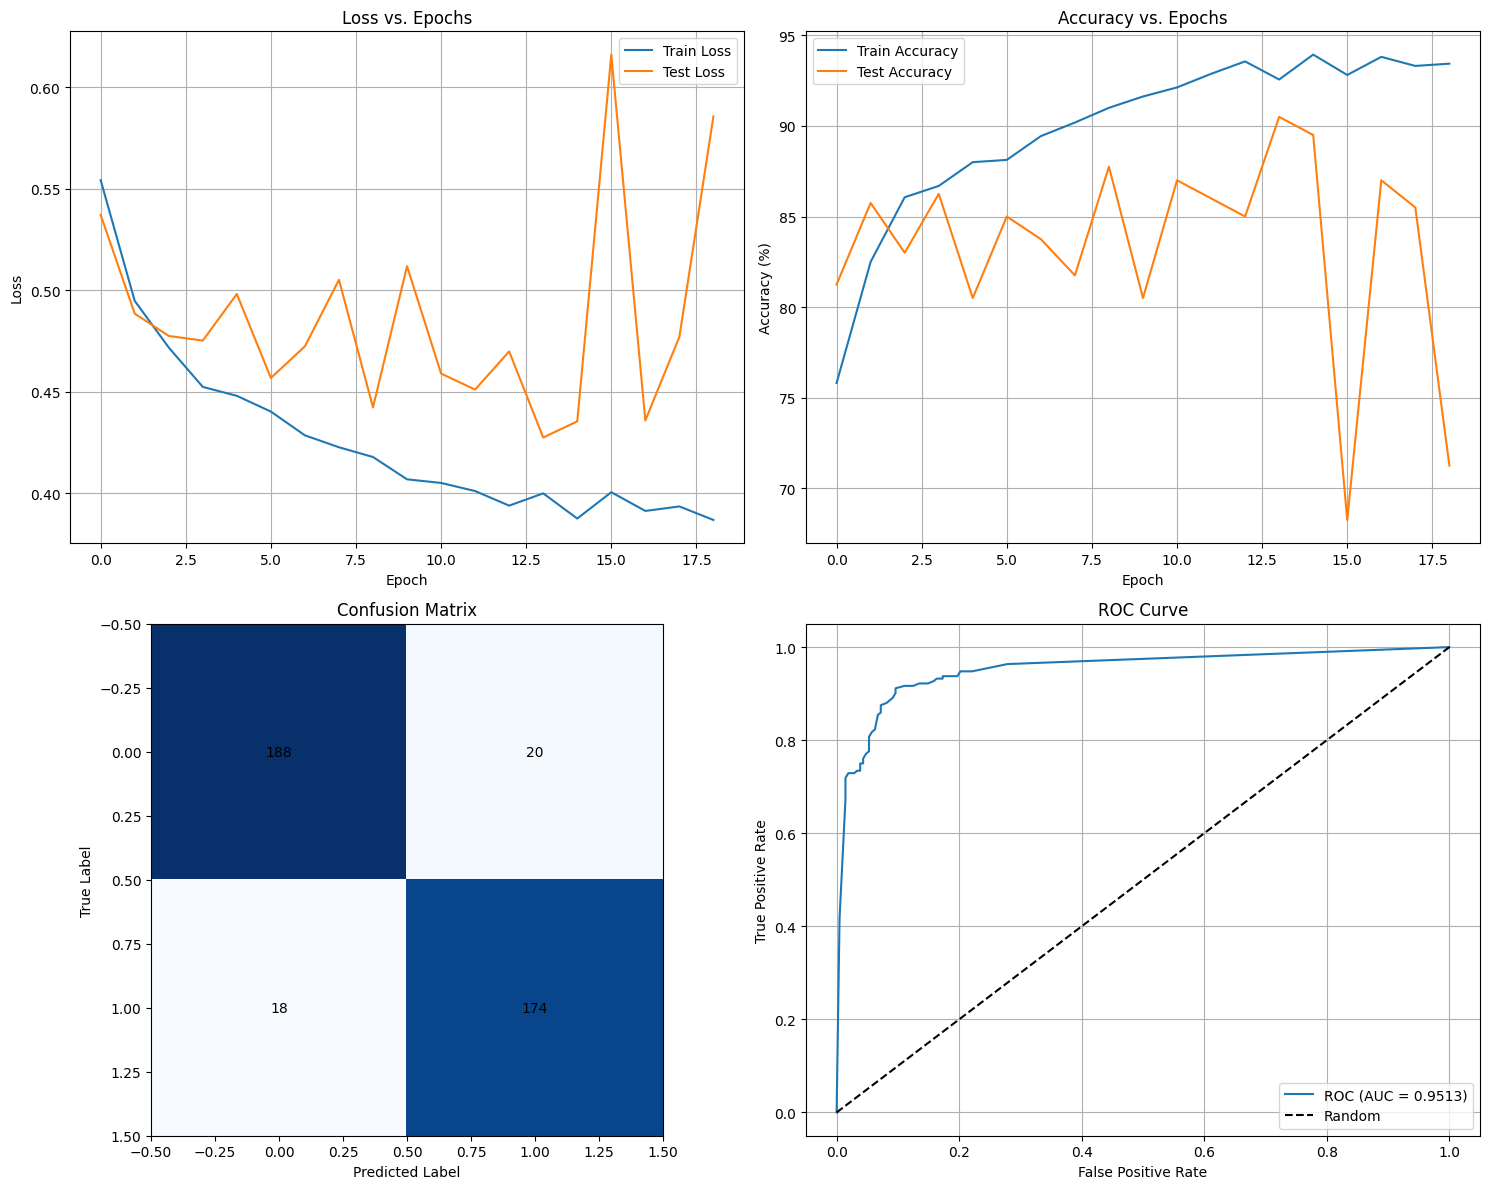

In [15]:
# ============= MAIN TRAINING LOOP =============
def main():
    """Main training and evaluation pipeline"""

    print("=" * 60)
    print("DRiVE: Dynamic Recognition in VEhicles using snnTorch")
    print("=" * 60)

    # 1. Data preparation
    print("\n[1] Loading and preprocessing data...")
    transform = get_transforms()

    """
    paths
    ✓ Vehicle directory: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/vehicles
    Total images: 8792
    ✓ Non-vehicle directory: /root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/non-vehicles
    Total images: 8968
    """
    # Load dataset (replace with your actual paths)
    dataset = VehicleDataset(
         vehicle_dir='/root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/vehicles',
         non_vehicle_dir='/root/.cache/kagglehub/datasets/brsdincer/vehicle-detection-image-set/versions/1/data/non-vehicles',
         transform=transform
    )

    # Split into train/test (80/20 split as in paper)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
         dataset, [train_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 2. Initialize model
    print("[2] Initializing DRiVE model...")
    model = DRiVE(
        input_size=IMG_SIZE * IMG_SIZE,
        hidden_size=HIDDEN_SIZE,
        output_size=2,
        beta=BETA
    ).to(device)

    print(f"Model architecture:\n{model}")
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

    # 3. Loss function and optimizer
    print("\n[3] Setting up training components...")
    # Cross-Entropy Rate Loss for spike trains
    loss_fn = SF.ce_rate_loss()

    # AdamW optimizer with learning rate 1e-3
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # 4. Training loop with early stopping
    print("\n[4] Starting training...")
    print(f"Configuration: {NUM_EPOCHS} epochs, batch size {BATCH_SIZE}, "
          f"LR {LEARNING_RATE}, {NUM_STEPS} time steps\n")

    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Uncomment to run actual training
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, loss_fn, device
        )

        # Evaluate
        test_loss, test_acc, _, _, _ = evaluate(
            model, test_loader, loss_fn, device
        )

        # Record metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'drive_best_model.pth')
            print(f"  ✓ Best model saved (loss: {best_loss:.4f})")
        else:
            epochs_no_improve += 1
            print(f"  No improvement ({epochs_no_improve}/{PATIENCE})")

        if epochs_no_improve == PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        print()

    # 5. Final evaluation
    print("\n[5] Final evaluation on best model...")
    model.load_state_dict(torch.load('drive_best_model.pth'))
    test_loss, test_acc, targets, predictions, spike_rates = evaluate(
        model, test_loader, loss_fn, device
    )

    print(f"\nFinal Test Accuracy: {test_acc:.2f}%")
    print(f"Final Test Loss: {test_loss:.4f}")

    # 6. Generate metrics
    print("\n[6] Generating evaluation metrics...")

    # Confusion Matrix
    cm = confusion_matrix(targets, predictions)
    print("\nConfusion Matrix:")
    print(cm)

    # ROC Curve and AUC
    spike_rates = np.array(spike_rates)
    fpr, tpr, _ = roc_curve(targets, spike_rates[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"\nAUC Score: {roc_auc:.4f}")

    # Plot results
    plot_results(train_losses, test_losses, train_accuracies,
                 test_accuracies, cm, fpr, tpr, roc_auc)

    """
    print("\n" + "=" * 60)
    print("Setup complete! Uncomment training code to run.")
    print("=" * 60)
    """

if __name__ == '__main__':
    main()